# Module 4 Time Series Project <br>


Name: Hazel Donaldson <br>
Pace: Part-Time <br>
Review Date: 10/21/2019 <br>
Instructor Name: Victor Geislinger

# 1) Introduction <br>

In this project, we will be performing a time series analysis on historical housing data obtained from Zillow. We will discover the top 5 zipcodes a real estate developer should invest in (buy homes, renovate and rent to people). This investor is looking for busy, dense metropolitan areas with average house prices around the median. 

# 2) Import necessary libraries, functions and import dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [34]:
def melt_data(df): #from Flatiron school
    melted = pd.melt(df, id_vars=['ZipCode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def get_datetimes(df):
    return pd.to_datetime(df.columns.values[6:], format='%Y-%m')

def acf_pacf(df, alags=48, plags=48):
    '''Creates the ACF and PACF plots to 
    observe possible parameters for ARIMA model'''
    #Create figure
    fig,(ax1, ax2) = plt.subplots(2,1, figsize=(13,8))
    #Create ACF plot
    plot_acf(df, lags=alags, zero=False, ax=ax1)
    #PACF plot
    plot_pacf(df, lags=plags, ax=ax2)
    plt.show()
    
def seasonal_plot(df, N=13, lags=[12,24,36,48,60,72]):
    #differencing the rolling mean to find seasonality in acf plot
    fig,(ax1, ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = df - df.rolling(N).mean()
    plot_acf(rolling.dropna(), lags=lags, ax=ax1)
    plot_pacf(rolling.dropna(), lags=lags, ax=ax2)
    plt.show();


def train_test(df):
    #Set training data before 2015
    train = df[:'2015-04']
    #Set test data starting 2015
    test = df['2015-05':]
    return train, test
  

def model_fit(df, pdq=(1,0,1), pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train, order= pdq, seasonal=pdqs)
    results = model.fit()
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show()
    return train, test, results

def forecast(df, pred_date, start_date):
    #make these global so they can be accessed later
    global pred
    global pred_conf
    
    #get predictions from specific date and calculate confidence intervals
    pred = output.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    
    #plot real vs predicted values
    rcParams['figure.figsize'] = 15,6
    
    #plot observed values
    ax = df[start_date:].plot(label='Observed')
    
    #plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-Step Forecast', alpha=.9)
    
    #plot range of confidence intervals
    ax.fill_between(pred_ci.index,
                   pred_ci.iloc[:,0],
                   pred_ci.iloc[:, 1], color = 'g', alpha=.5)
    #axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Monthly Returns')
    plt.legend()
    plt.show() 
    
    values_forecasted = pred.predicted_mean
    values_truth = df
    
    rmse = np.sqrt(mean_squared_error(values_truth[pred_date:], values_forecasted))
    print('RMSE: '+str(rmse))
    print('mean: '+str(df[pred_date:].mean()))

def dynamic_forecast(df, pred_date, start_date):
    #make variables global so they can be used outside of function
    global pred_dynamic
    global pred_dynamic_ci
    
    #get predictions from specific dates and calculate confidence intervals
    pred_dynamic = output.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    
    #plot dynamic forecast and confidence intervals
    ax = df[start_date:].plot(label='Observed', figsize=(20,15))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
    
    ax.fill_between(pred_dynamic_ci.index,
                   pred_dynamic_ci.iloc[:, 0],
                   pred_dynamic_ci.iloc[:, 1], color='g', alpha=.3)
    #ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(start_date), zipcode_forecasted.index[-1], alpha=.1, zorder=-1)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Monthly Returns')
    plt.legend()
    plt.show()
    
    values_forecasted = pred_dynamic.predicted_mean
    values_truth = df
    
    rmse = np.sqrt(mean_squared_error(values_truth[pred_date:], values_forecasted))
    print('RMSE: '+str(rmse))
    print('mean: '+str(df[pred_date:].mean()))

def future_forecast_model(df, pdq=(1,0,1), pdqs=(0,0,0,1), display=True, zc='input zipcode'):
    '''Forecast time series data up to 10-years. outputs monthly
    returns after 1yr, 3yrs, 5yrs and 10yrs for each zipcode'''
    model = SARIMAX(df, order=pdq, seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04', end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:, 1],
                       color= 'k', alpha=.25, label='Confidence Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

In [3]:
zillow_df = pd.read_csv('zillow_data.csv')
zillow_df.head()
print(zillow_df.info(), '\n')
print(f'Unique amount of zipcodes: {zillow_df.RegionName.nunique()}')
zillow_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB
None 

Unique amount of zipcodes: 14723


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
zillow_df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


Looking at our data set, I can see that it is provided in wide-format. Further down, I will transform the data set into long format so that it is easier to read. There are 14,723 unique zipcodes in the data, so the next step will be to select the zipcodes that fit the investor's interests.

# 3) Data Preprocessing

Before choosing zipcodes that will suit the investor's interest, we will rename the RegionName column to zipcode for simplicity. Then below, we will filter the zipcodes that are higly urbanized and dense. One of the investor's interest is investing in the state of Texas, so we will be focusing our analysis on that state.

In [5]:
zillow_df.rename(columns={'RegionName':'ZipCode'}, inplace=True)
zillow_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [9]:
#dataframe for texas
texas_df = zillow_df.loc[zillow_df['State'] == 'TX']
texas_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [10]:
# Find the zipcodes that are in highly urbanized areas
print(texas_df.SizeRank.describe())
#Calculate 20% cutoff point
srank_20 = texas_df.SizeRank.quantile(q=0.20)
print(f'Size Rank 20% cutoff value: {srank_20}')
#New dataframe
top_20_zc = texas_df[texas_df['SizeRank'] < srank_20].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(top_20_zc)}')

count      989.000000
mean      5901.627907
std       3922.628245
min          2.000000
25%       2560.000000
50%       5615.000000
75%       8936.000000
max      14696.000000
Name: SizeRank, dtype: float64
Size Rank 20% cutoff value: 1870.8000000000002
Amount of zipcodes: 198


The number of zipcodes has been narrowed down to 2,945 from 14,723. Now I will narrow down the zipcodes to housing prices that hover around the median price. The average value will be calculated from last year's data as this the data the investor is mostly likely to encounter.

In [11]:
top_20_zc['yr_avg'] = top_20_zc.iloc[:,-12:].mean(skipna=True, axis=1)
print(top_20_zc['yr_avg'].describe())
q_60 = top_20_zc['yr_avg'].quantile(q=0.60)
q_35 = top_20_zc['yr_avg'].quantile(q=0.35)
print(f'Average Value for 60% cutoff rate: {round(q_60, 2)}')
print(f'Average Value for 35% cutoff rate: {round(q_35, 2)}')
pref_zc = top_20_zc[(top_20_zc['yr_avg'] < q_60) & (top_20_zc['yr_avg'] > q_35)]
print(f'Amount of zipcodes: {len(pref_zc)}')

count    1.980000e+02
mean     2.263535e+05
std      1.133818e+05
min      6.877500e+04
25%      1.542042e+05
50%      1.985375e+05
75%      2.645146e+05
max      1.042375e+06
Name: yr_avg, dtype: float64
Average Value for 60% cutoff rate: 221956.67
Average Value for 35% cutoff rate: 172982.92
Amount of zipcodes: 50


The number of zipcodes to consider is now 736. This takes in some of the requirements the investor is looking for: urbanization and median home value. Now, its time to look at things from an investment standpoint and calculate the return on investment and the coefficient of variance to take into account the risks involved. The return on investment or ROI is percentage increase in price. I will be calculating the ROI  between 2013-2018. This will represent the areas with the highest recent price uptrend. 

On the other hand, the investor will want to select areas where there is low volatility. It lowers risks when housing prices drop. The coefficient of variance is also used here, it's defined by the standard deviation divided by the mean. All 22 years of data is used here and null values are skipped. The higher the coefficient, the more volatile the zipcode.

In [12]:
pref_zc['roi'] = (pref_zc['2018-04']- pref_zc['1996-04'])/pref_zc['1996-04']
#calculate the standard deviation of monthly values between 1996 to 2018
pref_zc['std'] = pref_zc.loc[:,'1996-04': '2018-04'].std(skipna=True, axis=1)
#calculate historic mean
pref_zc['mean'] = pref_zc.loc[:, '1996-04': '2018-04'].mean(skipna=True, axis=1)
#calculate the coefficient of variance
pref_zc['CV'] = pref_zc['std']/pref_zc['mean']
#show calculated values
pref_zc[['ZipCode', 'std', 'roi', 'CV']].head(10)

,ZipCode,std,roi,CV
25,79912,26245.575483,0.571429,0.170412
31,78130,23349.861603,0.784504,0.152247
34,75052,19370.586349,0.995040,0.144309
44,77036,16512.621894,0.576412,0.126514
77,78666,23596.375393,1.002910,0.171385
113,78240,22962.707088,0.831516,0.177248
136,76028,21474.688672,0.936008,0.157067
182,77095,22567.238470,0.667426,0.140926
304,77840,19764.360616,0.727953,0.137651
335,76116,21835.158904,1.188811,0.186596


In [13]:
#descriptive statistics for coefficient of variance
print(pref_zc['CV'].describe())
#define an upper limit for CV
upper_cv = pref_zc.CV.quantile(q=0.60)
print(f'Upper CV limit: {upper_cv}')
#get zipcodes with highest ROIs within risk profile
best_zc = pref_zc[pref_zc.CV < upper_cv].sort_values('roi', ascending=False, axis=0)[:5]
best_zc[['ZipCode', 'roi', 'CV']].head(20)

count    50.000000
mean      0.160347
std       0.024479
min       0.125338
25%       0.139902
50%       0.157315
75%       0.177343
max       0.223681
Name: CV, dtype: float64
Upper CV limit: 0.16422299636484086


,ZipCode,roi,CV
1617,75165,0.997886,0.158206
34,75052,0.995040,0.144309
1301,75104,0.954222,0.141479
136,76028,0.936008,0.157067
1185,76017,0.891841,0.149056


In [14]:
#get location names
best_zipcodes = list(best_zc.ZipCode.values)
for i in best_zipcodes:
    city = zillow_df[zillow_df['ZipCode']== i].City.values[0]
    state = zillow_df[zillow_df['ZipCode'] == i].State.values[0]
    print(f'Zipcode: {i}\n Location: {city}, {state}\n')

Zipcode: 75165
 Location: Waxahachie, TX

Zipcode: 75052
 Location: Grand Prairie, TX

Zipcode: 75104
 Location: Cedar Hill, TX

Zipcode: 76028
 Location: Burleson, TX

Zipcode: 76017
 Location: Arlington, TX



Now, we have the top 5 zipcodes based on our investor's interest. The data is still formatted in a wide format, with each month as a column. In order to perform a time series analysis, it needs to be formatted in long format, with month as a row.

In [15]:
TS_ZC5 = best_zc.drop(['yr_avg', 'std', 'mean', 'roi', 'CV'], axis=1)
TS_ZC5 =melt_data(TS_ZC5).set_index('time')
print('Time Series Data for top 5 zipcodes:\n', TS_ZC5.head())
dfs_ts = []
for zc in TS_ZC5.ZipCode.unique():
    df = TS_ZC5[TS_ZC5['ZipCode']==zc].asfreq('MS')
    dfs_ts.append(df)
dfs_ts[0].head()

Time Series Data for top 5 zipcodes:
             ZipCode     value
time                         
1996-04-01    75165   94600.0
1996-04-01    75052  100800.0
1996-04-01    75104   98300.0
1996-04-01    76028  104700.0
1996-04-01    76017  105400.0


,ZipCode,value
time,,
1996-04-01,75165,94600.0
1996-05-01,75165,94500.0
1996-06-01,75165,94500.0
1996-07-01,75165,94500.0
1996-08-01,75165,94500.0


# 4) EDA & Visualization

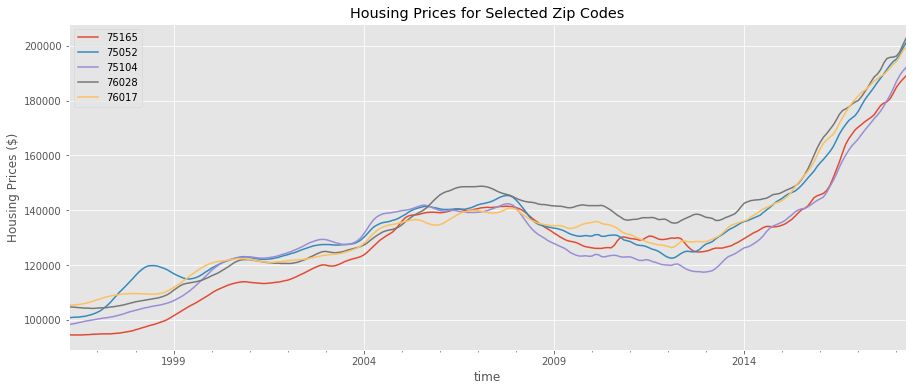

In [16]:
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].ZipCode[0], figsize=(15,6))
    plt.title('Housing Prices for Selected Zip Codes')
    plt.ylabel('Housing Prices ($)')
    plt.legend()

The graph above shows the prices are about the same for the 22 year period and I can see that the housing trends for Portland (97233) and Parkland(98444) got higher and fell around the time of the great housing crash and recession of 2009. There is a bit of the a dip in the Greeley(80631) trend around the time of the housing crash.

In [17]:
for i in range(len(dfs_ts)):
    print(f'Value descriptive statistics for zipcode {dfs_ts[i].ZipCode[0]}:')
    print(f'{dfs_ts[i].value.describe()}\n')

Value descriptive statistics for zipcode 75165:
count       265.000000
mean     128022.264151
std       20253.931403
min       94500.000000
25%      113900.000000
50%      129000.000000
75%      139000.000000
max      189000.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 75052:
count       265.000000
mean     134230.188679
std       19370.586349
min      100800.000000
25%      122800.000000
50%      130700.000000
75%      140800.000000
max      201100.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 75104:
count       265.000000
mean     129367.924528
std       18302.905606
min       98300.000000
25%      120400.000000
50%      126600.000000
75%      139500.000000
max      192100.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 76028:
count       265.000000
mean     136723.396226
std       21474.688672
min      104200.000000
25%      121400.000000
50%      137300.000000
75%      145000.000000
max     

Since most of the prices in the housing trend graph above are similar, we will need a better way to compare the zipcodes. We will look at the monthly returns because the returns are comparable to each other and prices are dependent to the previous price. The returns are more likely to be stationary and have a constant mean of zero.

In [25]:
# new column for monthly returns
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret'] = np.nan *len(dfs_ts)
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1] = (dfs_ts[zc].value.iloc[i+1]/dfs_ts[zc].value.iloc[i]) - 1

Before we can begin modeling, an important assumption needs to be confirmed: stationary. Stationary tells us that the mean is constant, the standard deviation is constant and there is not seasonality.

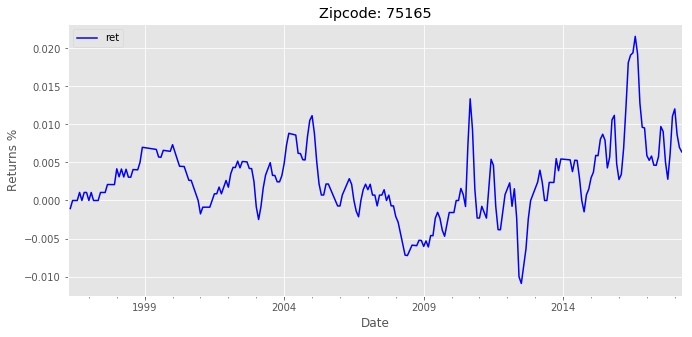

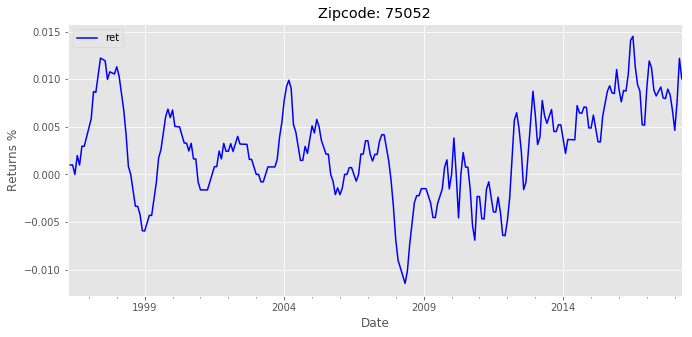

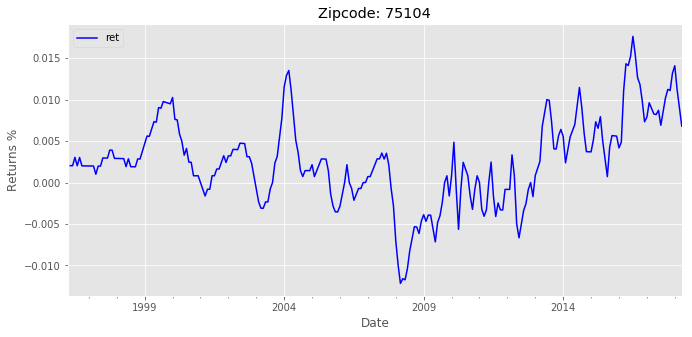

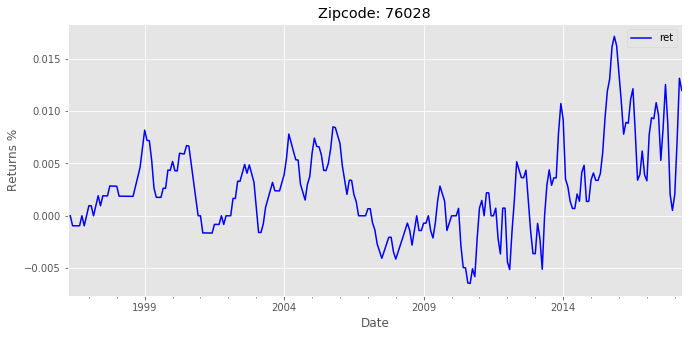

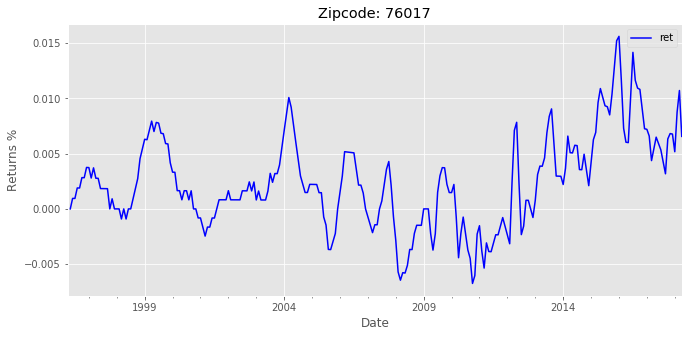

In [26]:
#plot the monthly returns for each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].ret.plot(figsize=(11, 5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].ZipCode[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns %')
    plt.legend(loc='best')
    plt.show()

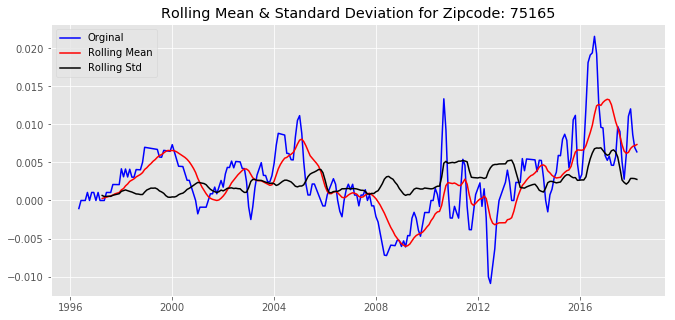

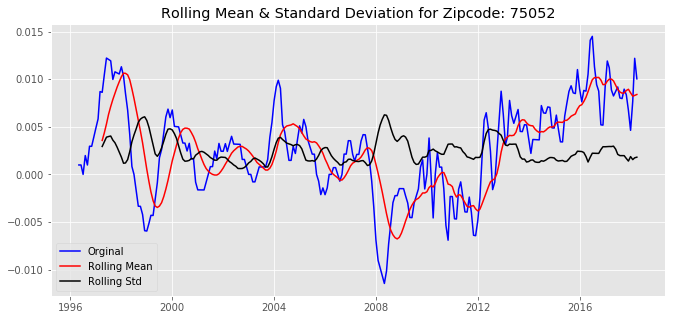

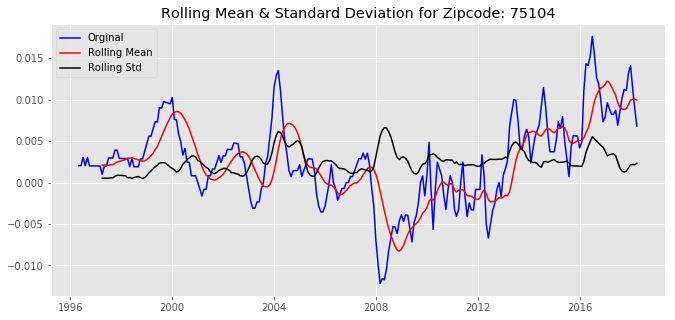

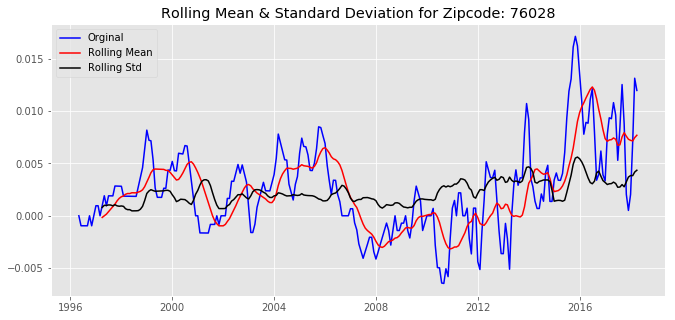

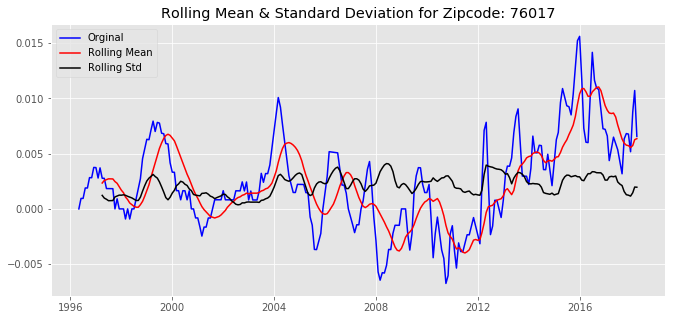

In [27]:
for i in range(len(dfs_ts)):
    rolmean= dfs_ts[i].ret.rolling(window=12, center=False).mean()
    rolstd = dfs_ts[i].ret.rolling(window=12, center=False).std()
    fig = plt.figure(figsize=(11, 5))
    orig = plt.plot(dfs_ts[i].ret,color='blue',label='Orginal')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].ZipCode[0]}')
    plt.show()

Visually, the data seems to not be stationary. However, we will challenge this visualizations using the Dickey-Fuller test and confirm whether or not the data is truly stationary. The Dickey-Fuller test is a statistical test of stationary in a time series. The null hypothesis of the Dickey-Fuller test say that the data is not stationary and the alternative hypothesis says the data is stationary. We will set the confidence level to 95% and we will reject the null hypothesis if there is p-value greater than 0.05.

In [28]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].ZipCode[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 75165
P-value 0.2536894623640273
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 75052
P-value 0.033314495565195126
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 75104
P-value 0.29915495031280925
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 76028
P-value 0.5059607412354552
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 76017
P-value 0.015859501160102343
Reject the null hypothesis. The data is stationary.



As we can see above, three of our zipcodes are not stationary and we will need to take the first difference to see the effect on stationary.

In [29]:
#take the first order of intergration
for i in [0,2,3]:
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].ZipCode[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 75165
P-value 1.1199428643882917e-08
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 75104
P-value 2.7620578229850713e-10
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 76028
P-value 2.7215687001353204e-10
Reject the null hypothesis. The data is stationary.



By taking the first difference of the data, all the data is now stationary. Moving forward, the I or integration for the ARIMA or SAMIRA model will be one. 

# 5) Time Series Analysis

In [30]:
#create individual times series for each zipcode
TS_75165 = dfs_ts[0].ret.dropna() #zipcode 75168 monthly returns time series
TS_75165d = dfs_ts[0].ret.diff().dropna() # differenced time series

TS_75052 = dfs_ts[1].ret.dropna() #zipcode 75168 monthly returns time series

TS_75104 = dfs_ts[2].ret.dropna() #zipcode 75168 monthly returns time series
TS_75104d = dfs_ts[2].ret.diff().dropna() # differenced time series

TS_76028 = dfs_ts[3].ret.dropna() #zipcode 75168 monthly returns time series
TS_76028d = dfs_ts[3].ret.diff().dropna() # differenced time series

TS_76017 = dfs_ts[4].ret.dropna() #zipcode 75168 monthly returns time series

## 5.1 Modelling Zipcode 75165(Waxahachie)

For our first analysis, we will be using the differenced data in order to ensure stationary in our plots below.

In [89]:
TS_75165['2018':].mean()

0.008513802527982117

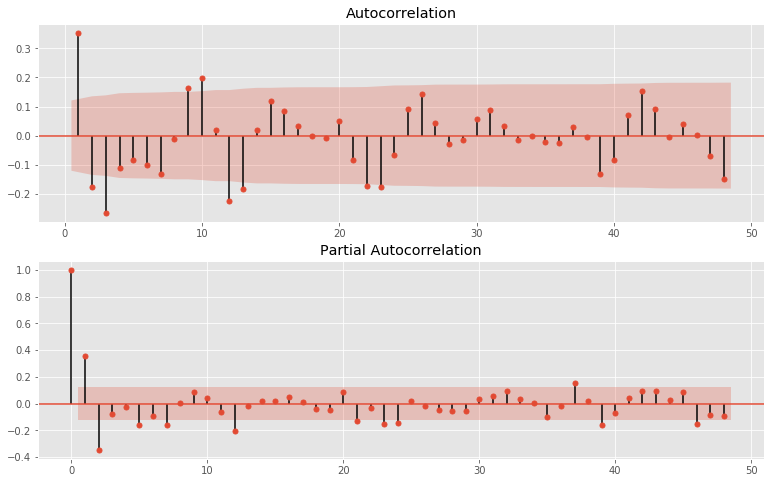

In [31]:
acf_pacf(TS_75165d)

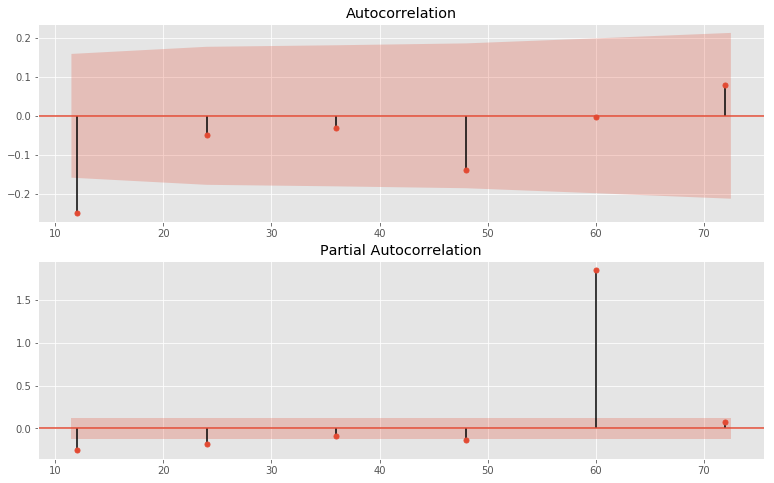

In [35]:
seasonal_plot(TS_75165d, N=13)

As we can see, there is a statistically significant lag at 12 in the autocorrelation plot and a slight statistically significant lag at 24 months in the partial autocorrelation plot which lends credence to the fact that there is seasonality in the data. So, we can move forward with seasonal ARIMA model or SARIMA model. The ARIMA model is the most common method in time series analysis, which stands for Auto-Regressive Integrated Moving Average.

The ARIMA model has three components: AR (auto-regression, the p-value) component allows us to incorporate the effect of past values on our model. For example, the price of flowers may be high because the price of flowers has been high for the past few months. The AR terms are lags of the dependent variable. For instance, if p is 5, the predictors of x(t) will be x(t-1)...x(t-5). 
Number of differences of integration (d-value) is the value of the amount of differencing as it identifies the number of lags to subtract from the current observations. This is similar to saying that price of flowers is likely to be high because the difference in the price of flowers in the last couple of months was small. 
The MA(moving average: q-value) component of the model is a linear combination of error values observed at different points in the past. For instance if the q-value in a model is 2, then x(t)'s predictors are e(t-1) and e(t-2). The term s is the periodicity of the time series(4 is quarterly periods and 12 is annual periods).

In [36]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

The AIC value or Akaike Information Criterion provided by the statsmodels library. AIC is an estimator of the relative quality of the statistical model of a given data set and provides a mean of model selection. A model with many features that fits the data well will be assigned a larger AIC value than a model with fewer features to acheive the same goodness of fit. Therefore, we are interested in a lowest AIC value possible.

In [37]:
ans = []
for comb in pdq:    
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_75165,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [38]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2579.42
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1137.292
Date:                Sun, 27 Oct 2019   AIC                          -2268.584
Time:                        14:13:20   BIC                          -2258.310
Sample:                    05-01-1996   HQIC                         -2264.438
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0911      0.127      0.715      0.475      -0.159       0.341
ma.L1          0.2818      0.122      2.306      0.021       0.042       0.521
sigma2      2.587e-06   1.57e-07     16.434      0.0

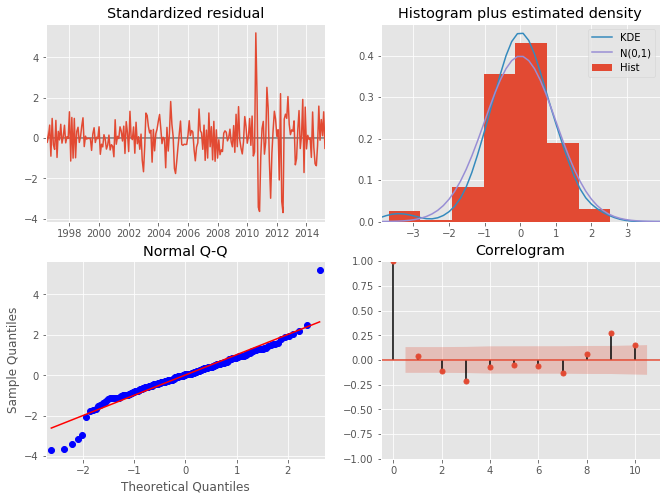

(time
 1996-05-01   -0.001057
 1996-06-01    0.000000
 1996-07-01    0.000000
 1996-08-01    0.000000
 1996-09-01    0.001058
 1996-10-01    0.000000
 1996-11-01    0.001057
 1996-12-01    0.001056
 1997-01-01    0.000000
 1997-02-01    0.001055
 1997-03-01    0.000000
 1997-04-01    0.000000
 1997-05-01    0.000000
 1997-06-01    0.001054
 1997-07-01    0.001053
 1997-08-01    0.001052
 1997-09-01    0.002101
 1997-10-01    0.002096
 1997-11-01    0.002092
 1997-12-01    0.002088
 1998-01-01    0.004167
 1998-02-01    0.003112
 1998-03-01    0.004137
 1998-04-01    0.003090
 1998-05-01    0.004107
 1998-06-01    0.003067
 1998-07-01    0.003058
 1998-08-01    0.004065
 1998-09-01    0.004049
 1998-10-01    0.004032
                 ...   
 2012-11-01    0.000000
 2012-12-01    0.000801
 2013-01-01    0.001601
 2013-02-01    0.002398
 2013-03-01    0.003987
 2013-04-01    0.002383
 2013-05-01    0.000000
 2013-06-01    0.000000
 2013-07-01    0.002377
 2013-08-01    0.002372
 2013-09-0

In [40]:
#Fit parameters for ARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
model_fit(TS_75165, pdq, pdqs)

From the above plots, we can see that the KDE curve is relatively close to the N(0,1) curve which indicates that the residuals are normally distributed. The Q-Q plot also shows us that the residuals are normally distributed because the blue dots(the residuals) are along the red line(normal distribution). The graph at the top left, doesn't show any obvious seasonality and appears to be white noise.This is confirmed with the graph at the bottom right because the time series residuals have a low correlation with lagged verisons of themselves.
 
The next step after fitting the model is to validate the model by comparing the predicted value to real values to the accuracy of our model.

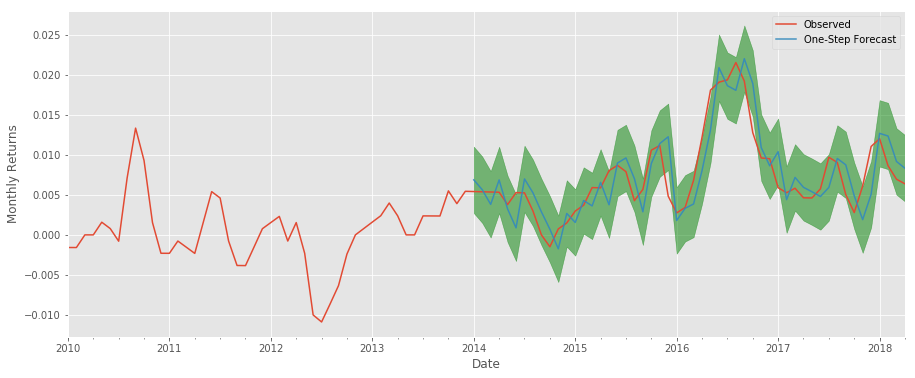

RMSE: 0.0028094887491539387
mean: 0.007384235335635954


In [41]:
#from forecast function above
forecast(TS_75165,'2014-01-01', '2010-01-01')

As we can see from the graph above, the one step forecast seems to align with the true values very well. It will also be useful to quantity the accuracy of our forecasts. We will use the MSE or mean squared error, which summarizes the average error of our forecasts. 

With dynamic forecasting we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

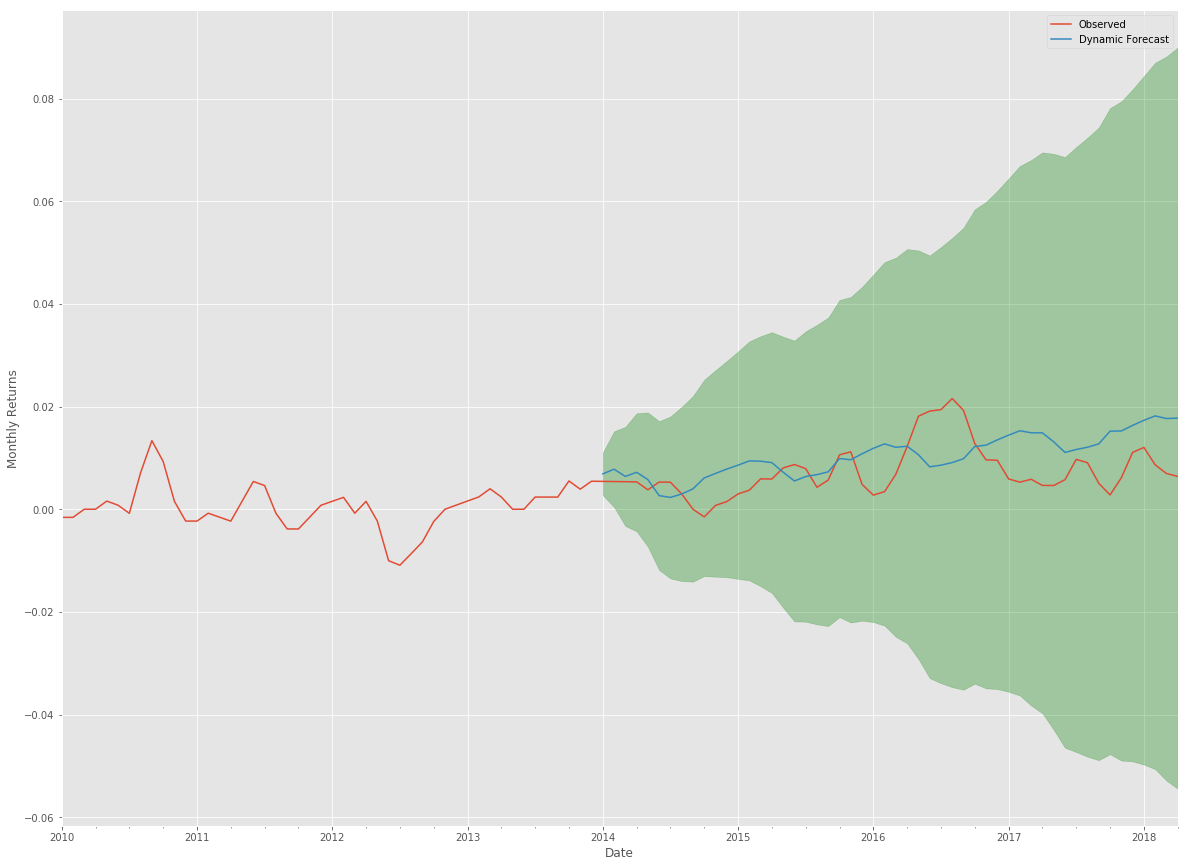

RMSE: 0.006574245400721037
mean: 0.007384235335635954


In [42]:
#from dynamic_forecast function above
dynamic_forecast(TS_75165,'2014-01-01', '2010-01-01')

The predicted values obtained from the dynamic forecast is 1.67e-5 which is slightly smaller than the one step forecast. Both the one step forecast and the dynamic forecast confirm that our time series is value. To complete this zipcode's time series analysis, we will predict up to the 10 year monthly returns.

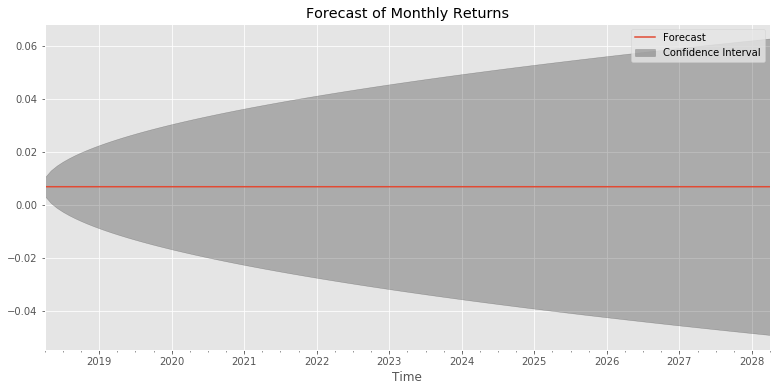

Total expected return in 1 year: 8.49%
Total expected return in 3 years: 27.68%
Total expected return in 5 year: 50.27%
Total expected return in 10 years: 127.34%


[75165,
 0.08486340449474117,
 0.2767934193153274,
 0.5026789813839903,
 1.2734106205522737]

In [43]:
#from future_forecast_model function above
ret_75165 = future_forecast_model(TS_75165, pdq = pdq, pdqs = pdqs,zc= 75165)
ret_75165

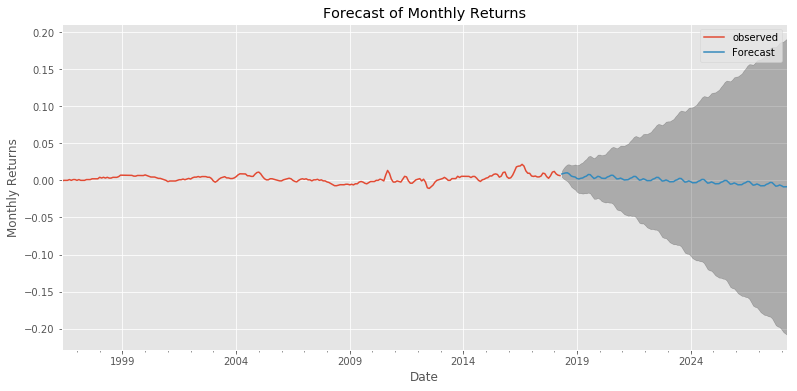

In [45]:
#get a forecast steps ahead in the future
#10 years in the future = 120 steps
prediction = output.get_forecast(steps=120)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

#plot future predictions with confidence intervals

ax = TS_75165.plot(label='observed', figsize=(13,6))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:, 0],
                   pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_title('Forecast of Monthly Returns')
ax.set_ylabel('Monthly Returns')

plt.legend()
plt.show()

## 5.2 Modelling Zipcode 75052(Grand Prairie)

Unlike the previous data, the data was stationary so the plots for the ACF and PACF will use the normal time series dataframe. The 'I' in the model will also be zero.

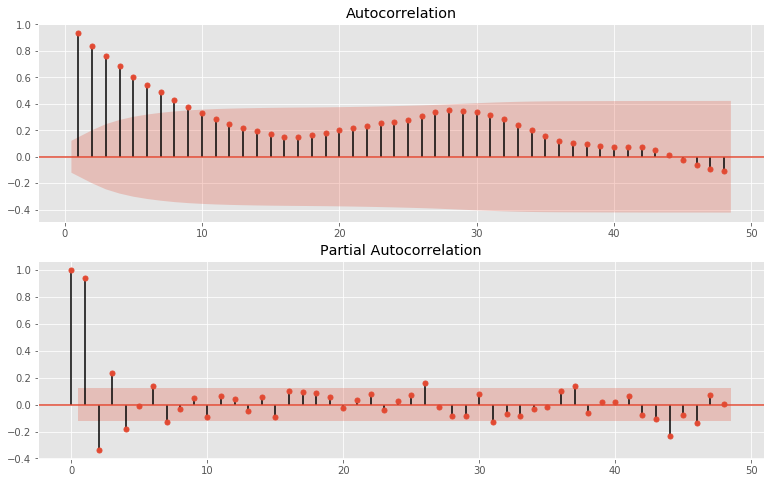

In [46]:
acf_pacf(TS_75052)

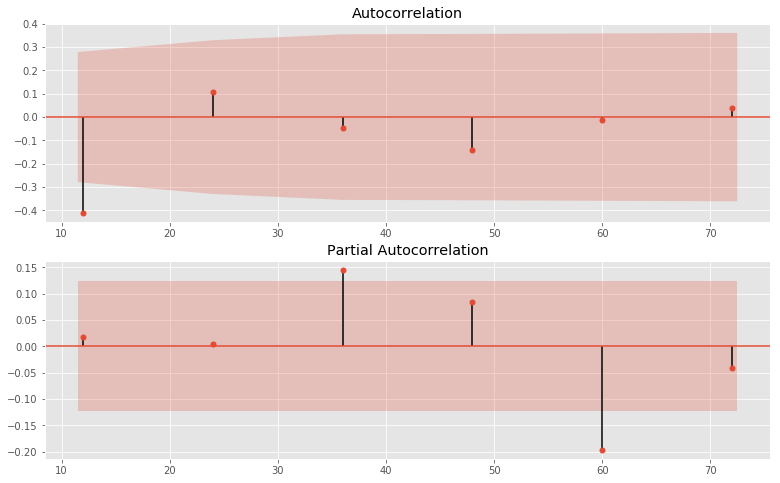

In [47]:
seasonal_plot(TS_75052, N=13)

In [48]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [49]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_75052,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [50]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic             -2639
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1158.842
Date:                Sun, 27 Oct 2019   AIC                          -2311.685
Time:                        14:16:14   BIC                          -2301.397
Sample:                    05-01-1996   HQIC                         -2307.534
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9026      0.030     29.882      0.000       0.843       0.962
ma.L1          0.3871      0.060      6.505      0.000       0.270       0.504
sigma2      2.218e-06   1.91e-07     11.582      0.0

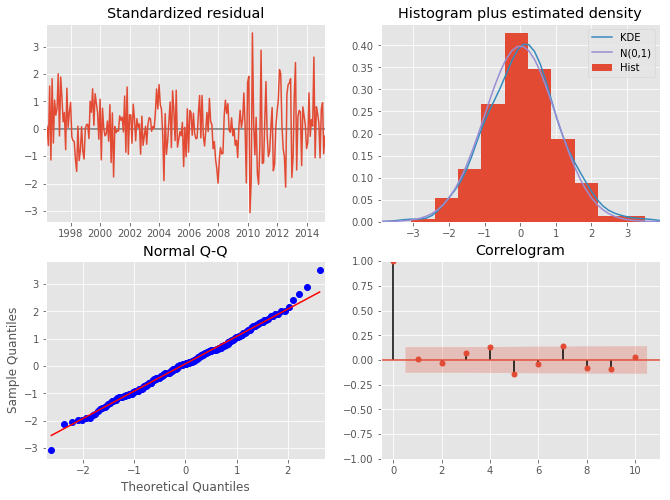

(time
 1996-05-01    0.000992
 1996-06-01    0.000991
 1996-07-01    0.000000
 1996-08-01    0.001980
 1996-09-01    0.000988
 1996-10-01    0.002962
 1996-11-01    0.002953
 1996-12-01    0.003925
 1997-01-01    0.004888
 1997-02-01    0.005837
 1997-03-01    0.008704
 1997-04-01    0.008629
 1997-05-01    0.010456
 1997-06-01    0.012230
 1997-07-01    0.012082
 1997-08-01    0.011938
 1997-09-01    0.009982
 1997-10-01    0.010782
 1997-11-01    0.010667
 1997-12-01    0.010554
 1998-01-01    0.011314
 1998-02-01    0.010327
 1998-03-01    0.008518
 1998-04-01    0.006757
 1998-05-01    0.004195
 1998-06-01    0.000835
 1998-07-01    0.000000
 1998-08-01   -0.001669
 1998-09-01   -0.003344
 1998-10-01   -0.003356
                 ...   
 2012-11-01    0.005596
 2012-12-01    0.008744
 2013-01-01    0.006304
 2013-02-01    0.003132
 2013-03-01    0.003903
 2013-04-01    0.007776
 2013-05-01    0.006173
 2013-06-01    0.005368
 2013-07-01    0.006102
 2013-08-01    0.006823
 2013-09-0

In [52]:
#Fit parameters for ARIMA model
pdq = (1,0,1)
pdqs = (0,0,0,12)
model_fit(TS_75052, pdq, pdqs)

From above, we can see that the KDE plot fits the N(0,1) closely and the the residuals on the the Q-Q plot closely follows that normally distributed line which tells us that the residuals are probably normally distributed. The standardized residual plot looks like mostly white noise and the autocorrelation plot shows us that the residuals are not closely related to lagged verisons of themselves. Now, we can validate our forecast.

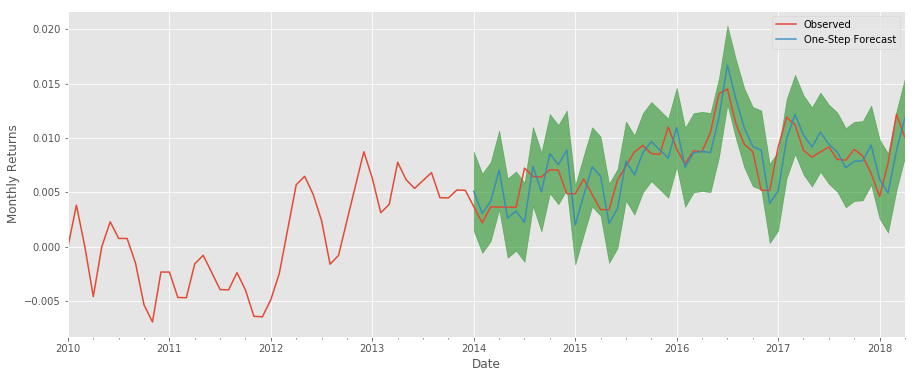

RMSE: 0.0020210880976493065
mean: 0.007639938298165014


In [53]:
forecast(TS_75052,'2014-01-01', '2010-01-01')

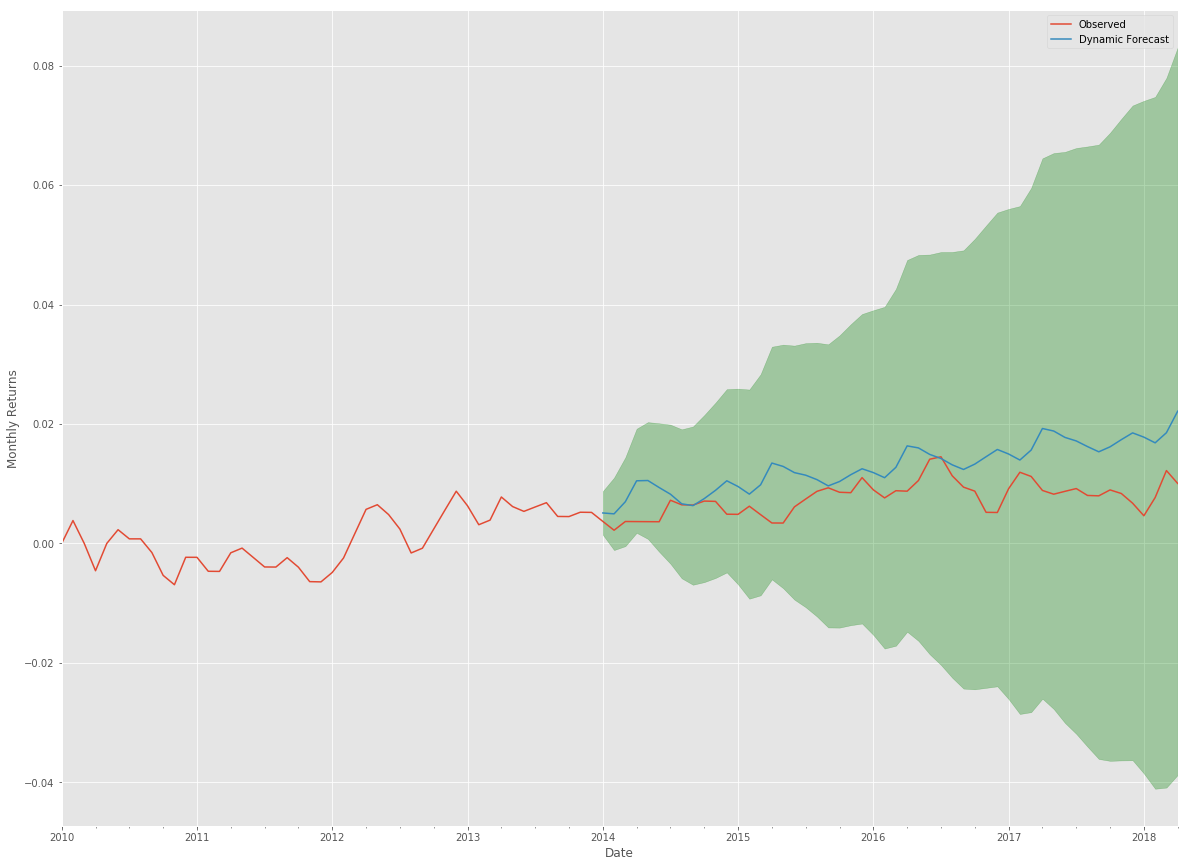

RMSE: 0.006364031384519879
mean: 0.007639938298165014


In [54]:
dynamic_forecast(TS_75052,'2014-01-01', '2010-01-01')

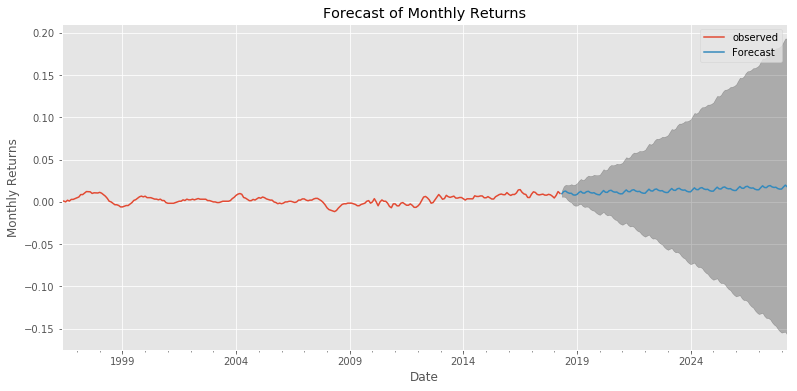

In [55]:
#get a forecast steps ahead in the future
#10 years in the future = 120 steps
prediction = output.get_forecast(steps=120)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

#plot future predictions with confidence intervals

ax = TS_75052.plot(label='observed', figsize=(13,6))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:, 0],
                   pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_title('Forecast of Monthly Returns')
ax.set_ylabel('Monthly Returns')

plt.legend()
plt.show()

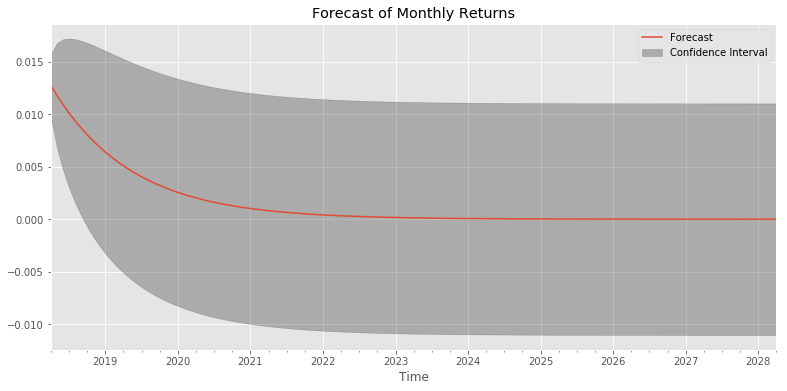

Total expected return in 1 year: 10.86%
Total expected return in 3 years: 17.46%
Total expected return in 5 year: 18.55%
Total expected return in 10 years: 18.76%


[75052,
 0.10858269784322849,
 0.17459130937078715,
 0.18550622907444736,
 0.1875730636170001]

In [56]:
ret_75052 = future_forecast_model(TS_75052, pdq = pdq, pdqs = pdqs,zc=75052)
ret_75052

## 5.3 Modelling Zipcode 75104(Cedar Hills)

Similar to the other monthly returns, because the data was not stationary we will use the differenced data in the ACF & PACF plots.

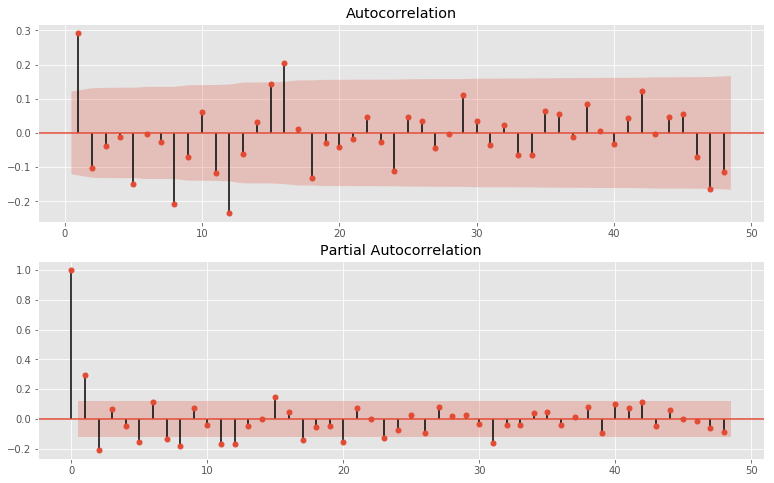

In [57]:
acf_pacf(TS_75104d)

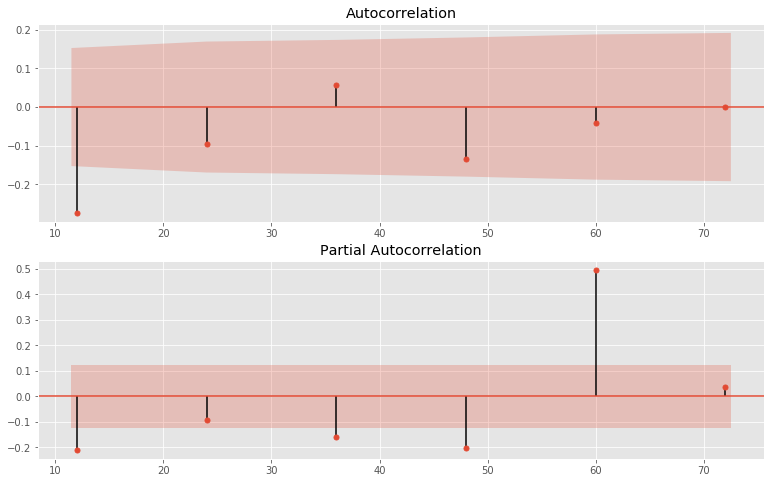

In [58]:
seasonal_plot(TS_75104d, N=13)

While there is a statistically significant lag at 12 months, there are no other significant lags at other 12 month intervals, so it is probable that there is no seasonality in the data. Now, we will find the parameter for the model.

In [59]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_75104,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [60]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2626.49
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1143.958
Date:                Sun, 27 Oct 2019   AIC                          -2281.916
Time:                        14:20:16   BIC                          -2271.641
Sample:                    05-01-1996   HQIC                         -2277.770
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2461      0.120     -2.055      0.040      -0.481      -0.011
ma.L1          0.6132      0.101      6.096      0.000       0.416       0.810
sigma2      2.444e-06   2.09e-07     11.673      0.0

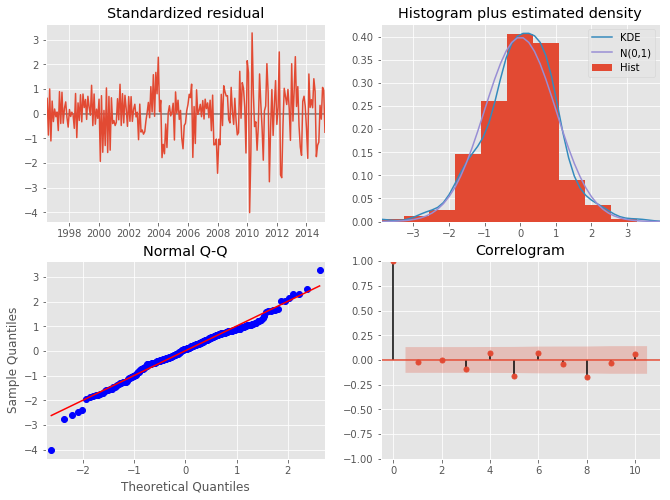

(time
 1996-05-01    0.002035
 1996-06-01    0.002030
 1996-07-01    0.003040
 1996-08-01    0.002020
 1996-09-01    0.003024
 1996-10-01    0.002010
 1996-11-01    0.002006
 1996-12-01    0.002002
 1997-01-01    0.001998
 1997-02-01    0.001994
 1997-03-01    0.001990
 1997-04-01    0.000993
 1997-05-01    0.001984
 1997-06-01    0.001980
 1997-07-01    0.002964
 1997-08-01    0.002956
 1997-09-01    0.002947
 1997-10-01    0.003918
 1997-11-01    0.003902
 1997-12-01    0.002915
 1998-01-01    0.002907
 1998-02-01    0.002899
 1998-03-01    0.002890
 1998-04-01    0.002882
 1998-05-01    0.001916
 1998-06-01    0.002868
 1998-07-01    0.001907
 1998-08-01    0.001903
 1998-09-01    0.001899
 1998-10-01    0.002844
                 ...   
 2012-11-01    0.000000
 2012-12-01   -0.001701
 2013-01-01    0.000852
 2013-02-01    0.001702
 2013-03-01    0.002549
 2013-04-01    0.006780
 2013-05-01    0.008418
 2013-06-01    0.010017
 2013-07-01    0.009917
 2013-08-01    0.007365
 2013-09-0

In [61]:
#Fit parameters for ARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
model_fit(TS_75104, pdq, pdqs)

One of the coefficients is not statistically significant but we can see the residuals are mostly normal with the tails in the Q-Q plot taper off. The standardized residuals also shows some white noise. 

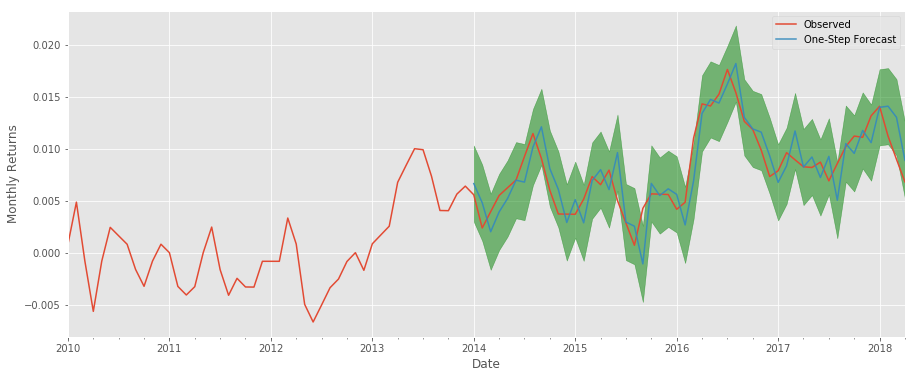

RMSE: 0.0020725630658450923
mean: 0.008211815404932047


In [62]:
forecast(TS_75104,'2014-01-01', '2010-01-01')

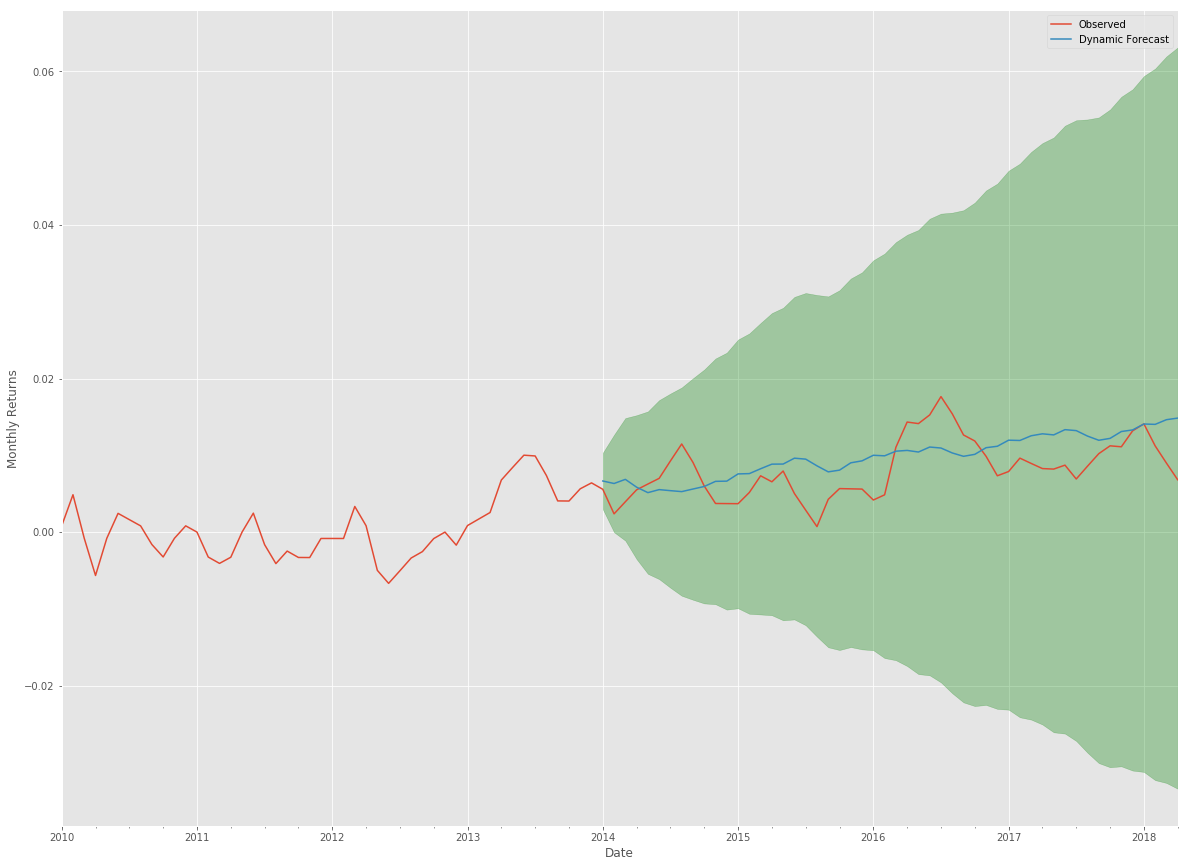

RMSE: 0.0038668924060470716
mean: 0.008211815404932047


In [63]:
dynamic_forecast(TS_75104,'2014-01-01', '2010-01-01')

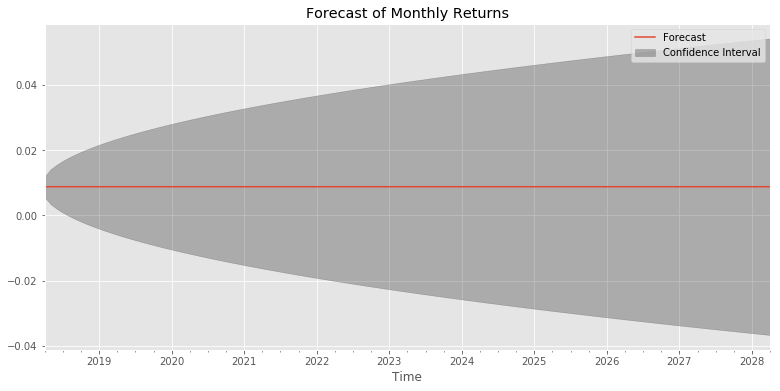

Total expected return in 1 year: 11.04%
Total expected return in 3 years: 36.91%
Total expected return in 5 year: 68.81%
Total expected return in 10 years: 187.47%


[75104,
 0.11035972679739947,
 0.36907339532945627,
 0.6880673141905786,
 1.8746664558851638]

In [64]:
ret_75104 = future_forecast_model(TS_75104, pdq = pdq, pdqs = pdqs,zc=75104)
ret_75104

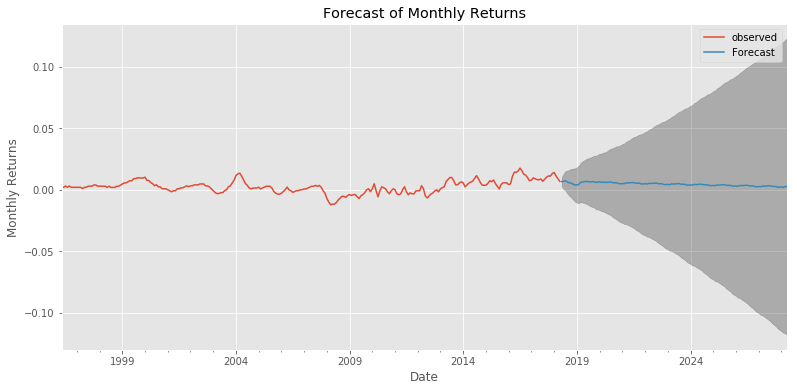

In [65]:
#get a forecast steps ahead in the future
#10 years in the future = 120 steps
prediction = output.get_forecast(steps=120)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

#plot future predictions with confidence intervals

ax = TS_75104.plot(label='observed', figsize=(13,6))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:, 0],
                   pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_title('Forecast of Monthly Returns')
ax.set_ylabel('Monthly Returns')

plt.legend()
plt.show()

## 5.4 Modelling Zipcode 76028(Burleson)

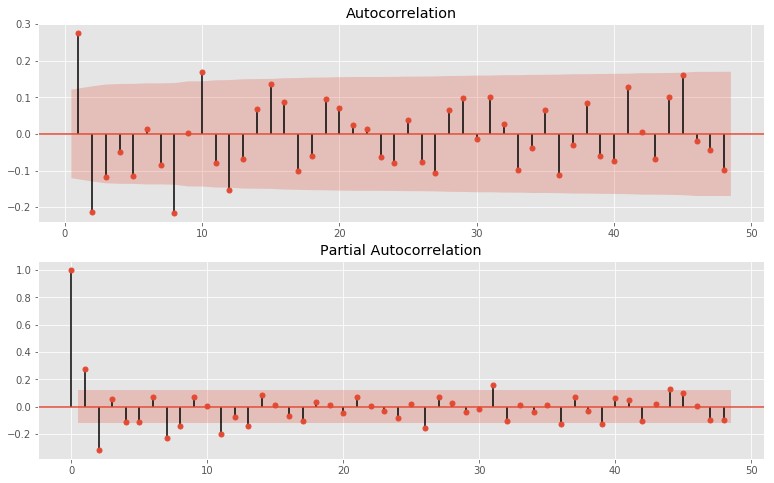

In [66]:
acf_pacf(TS_76028d)

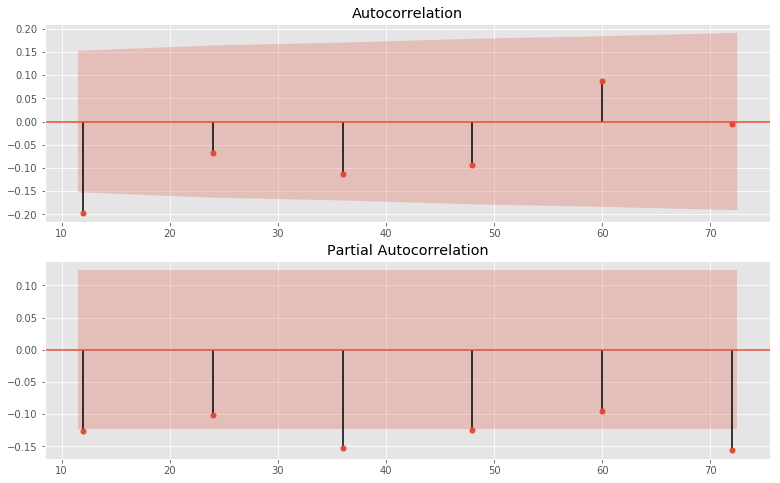

In [67]:
seasonal_plot(TS_76028d, N=13)

In [68]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_76028,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [69]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2625.22
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1166.539
Date:                Sun, 27 Oct 2019   AIC                          -2327.079
Time:                        14:23:35   BIC                          -2316.804
Sample:                    05-01-1996   HQIC                         -2322.933
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2974      0.140     -2.123      0.034      -0.572      -0.023
ma.L1          0.5978      0.110      5.459      0.000       0.383       0.812
sigma2      1.998e-06   1.31e-07     15.242      0.0

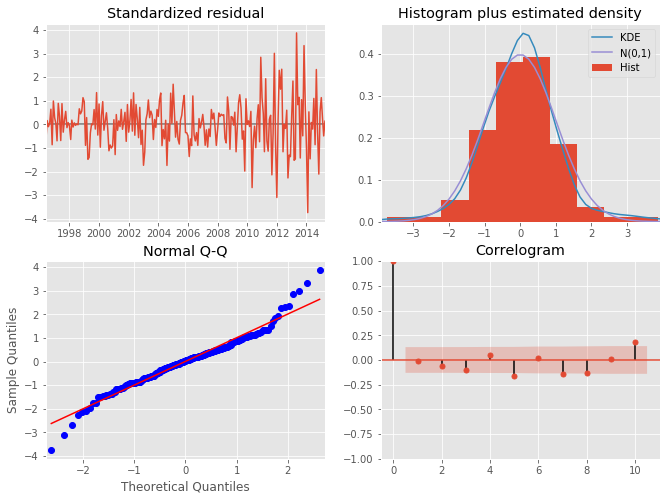

(time
 1996-05-01    0.000000
 1996-06-01   -0.000955
 1996-07-01   -0.000956
 1996-08-01   -0.000957
 1996-09-01   -0.000958
 1996-10-01    0.000000
 1996-11-01   -0.000959
 1996-12-01    0.000000
 1997-01-01    0.000960
 1997-02-01    0.000959
 1997-03-01    0.000000
 1997-04-01    0.000958
 1997-05-01    0.001914
 1997-06-01    0.000955
 1997-07-01    0.001908
 1997-08-01    0.001905
 1997-09-01    0.001901
 1997-10-01    0.002846
 1997-11-01    0.002838
 1997-12-01    0.002830
 1998-01-01    0.002822
 1998-02-01    0.001876
 1998-03-01    0.001873
 1998-04-01    0.001869
 1998-05-01    0.001866
 1998-06-01    0.001862
 1998-07-01    0.001859
 1998-08-01    0.001855
 1998-09-01    0.002778
 1998-10-01    0.003693
                 ...   
 2012-11-01   -0.001443
 2012-12-01   -0.003613
 2013-01-01   -0.003626
 2013-02-01   -0.000728
 2013-03-01   -0.002185
 2013-04-01   -0.005109
 2013-05-01    0.000000
 2013-06-01    0.002935
 2013-07-01    0.004389
 2013-08-01    0.002913
 2013-09-0

In [71]:
#Fit parameters for ARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
model_fit(TS_76028, pdq, pdqs)

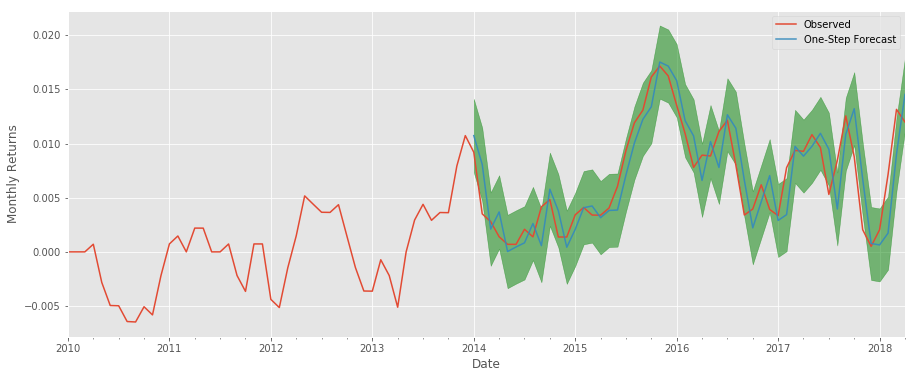

RMSE: 0.0024338946522520694
mean: 0.00697345400881107


In [72]:
forecast(TS_76028,'2014-01-01', '2010-01-01')

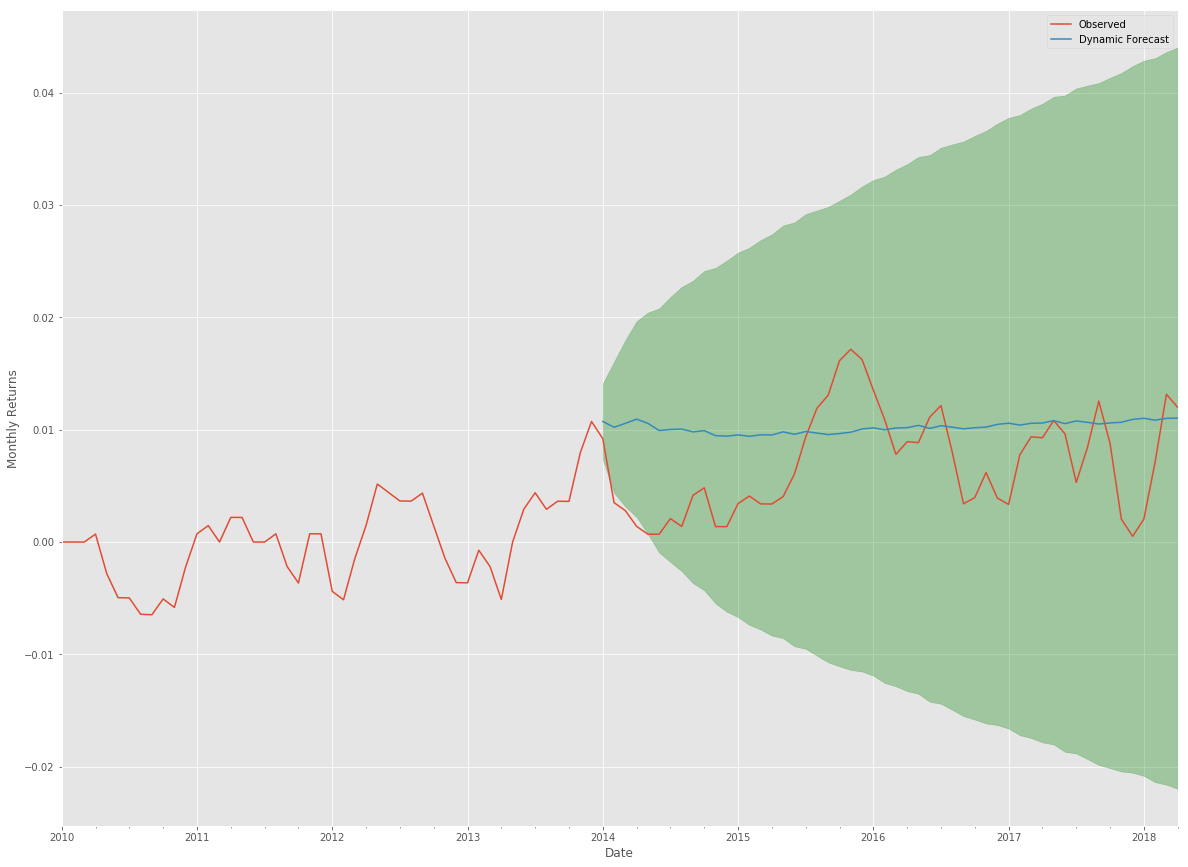

RMSE: 0.005560465501446013
mean: 0.00697345400881107


In [73]:
dynamic_forecast(TS_76028,'2014-01-01', '2010-01-01')

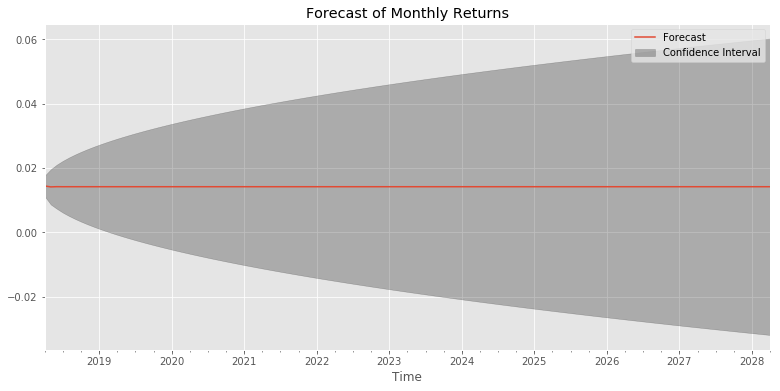

Total expected return in 1 year: 18.41%
Total expected return in 3 years: 65.96%
Total expected return in 5 year: 132.61%
Total expected return in 10 years: 448.63%


[76028,
 0.18410451434768027,
 0.6596145131085001,
 1.3260787360699955,
 4.486260544847844]

In [74]:
ret_76028 = future_forecast_model(TS_76028, pdq = pdq, pdqs = pdqs,zc=76028)
ret_76028

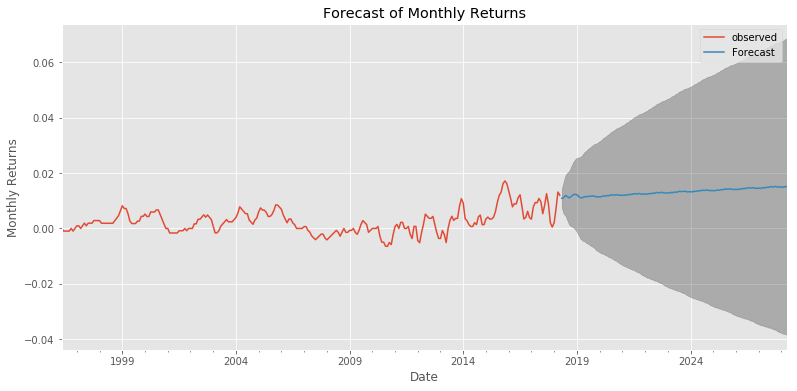

In [75]:
#get a forecast steps ahead in the future
#10 years in the future = 120 steps
prediction = output.get_forecast(steps=120)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

#plot future predictions with confidence intervals

ax = TS_76028.plot(label='observed', figsize=(13,6))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:, 0],
                   pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_title('Forecast of Monthly Returns')
ax.set_ylabel('Monthly Returns')

plt.legend()
plt.show()

## 5.5 Modelling Zipcode 76017(Arlington)

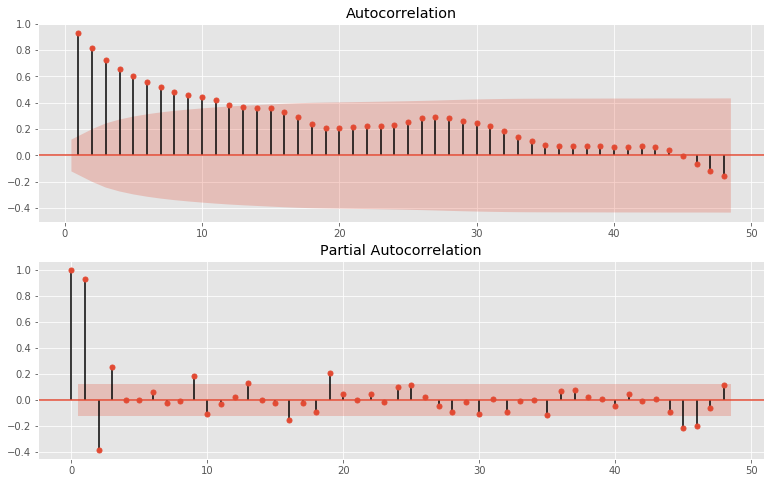

In [76]:
acf_pacf(TS_76017)

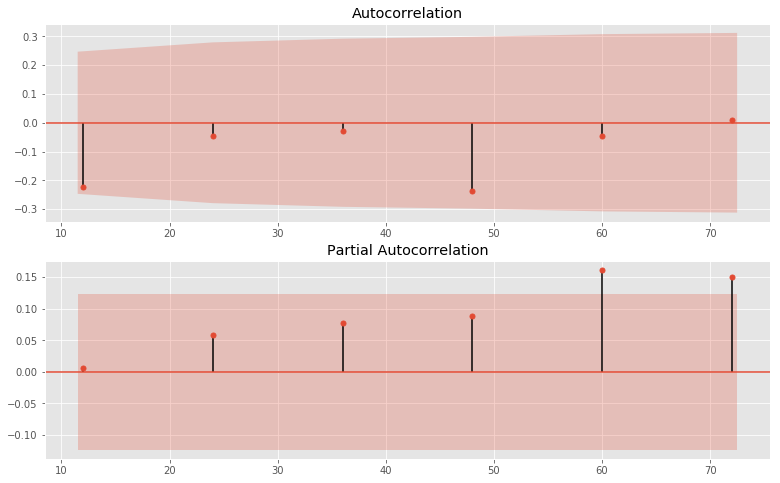

In [77]:
seasonal_plot(TS_76017, N=13)

In [78]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_76017,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [79]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2701.62
Name: 40, dtype: object

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  228
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1195.301
Date:                Sun, 27 Oct 2019   AIC                          -2384.603
Time:                        14:26:34   BIC                          -2374.315
Sample:                    05-01-1996   HQIC                         -2380.452
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8875      0.033     27.147      0.000       0.823       0.952
ma.L1          0.4646      0.057      8.171      0.000       0.353       0.576
sigma2      1.618e-06   1.22e-07     13.226      0.0

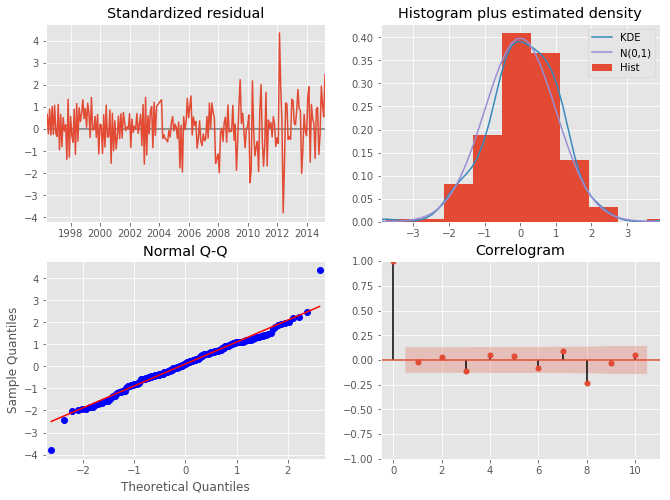

(time
 1996-05-01    0.000000
 1996-06-01    0.000949
 1996-07-01    0.000948
 1996-08-01    0.001894
 1996-09-01    0.001890
 1996-10-01    0.002830
 1996-11-01    0.002822
 1996-12-01    0.003752
 1997-01-01    0.003738
 1997-02-01    0.002793
 1997-03-01    0.003714
 1997-04-01    0.002775
 1997-05-01    0.002768
 1997-06-01    0.001840
 1997-07-01    0.001837
 1997-08-01    0.001833
 1997-09-01    0.001830
 1997-10-01    0.000000
 1997-11-01    0.000913
 1997-12-01    0.000000
 1998-01-01    0.000000
 1998-02-01    0.000000
 1998-03-01   -0.000912
 1998-04-01    0.000000
 1998-05-01   -0.000913
 1998-06-01    0.000000
 1998-07-01    0.000000
 1998-08-01    0.000914
 1998-09-01    0.001826
 1998-10-01    0.002735
                 ...   
 2012-11-01    0.000000
 2012-12-01   -0.000778
 2013-01-01    0.000778
 2013-02-01    0.003110
 2013-03-01    0.003876
 2013-04-01    0.003861
 2013-05-01    0.004615
 2013-06-01    0.006891
 2013-07-01    0.008365
 2013-08-01    0.009050
 2013-09-0

In [81]:
#Fit parameters for ARIMA model
pdq = (1,0,1)
pdqs = (0,0,0,12)
model_fit(TS_76017, pdq, pdqs)

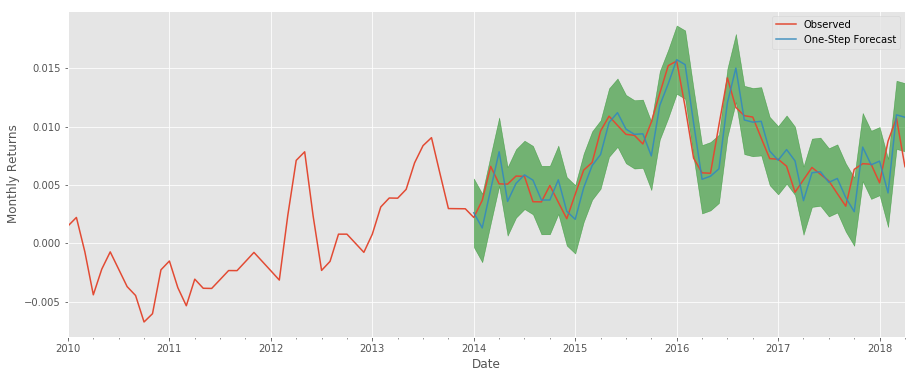

RMSE: 0.0018651841976954496
mean: 0.007419583892303862


In [82]:
forecast(TS_76017,'2014-01-01', '2010-01-01')

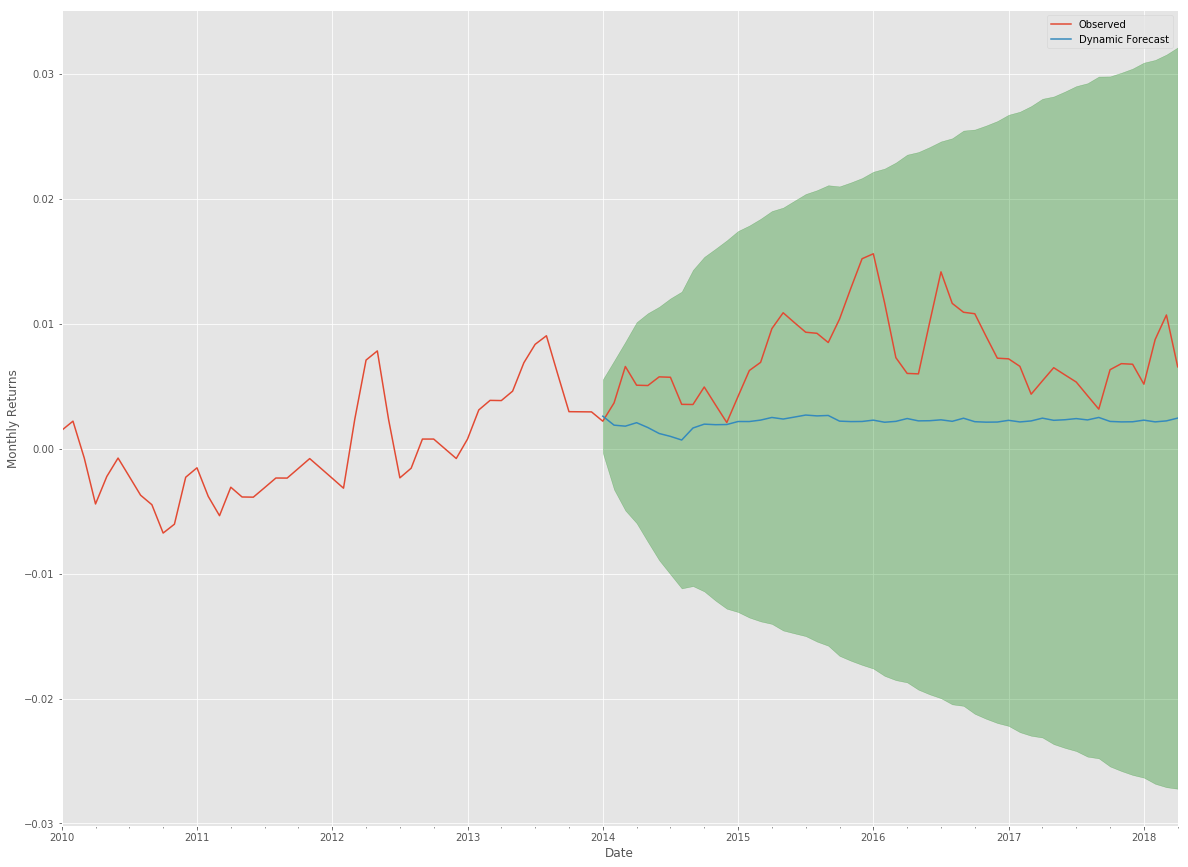

RMSE: 0.0061120082818224225
mean: 0.007419583892303862


In [83]:
dynamic_forecast(TS_76017,'2014-01-01', '2010-01-01')

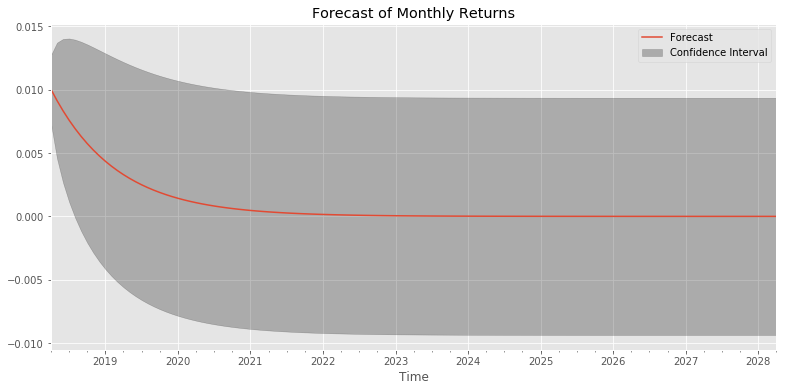

Total expected return in 1 year: 7.88%
Total expected return in 3 years: 11.51%
Total expected return in 5 year: 11.91%
Total expected return in 10 years: 11.96%


[76017,
 0.07875872916927484,
 0.11511047040209332,
 0.11910414220713594,
 0.11958589105349016]

In [84]:
ret_76017 = future_forecast_model(TS_76017, pdq = pdq, pdqs = pdqs,zc=76017)
ret_76017

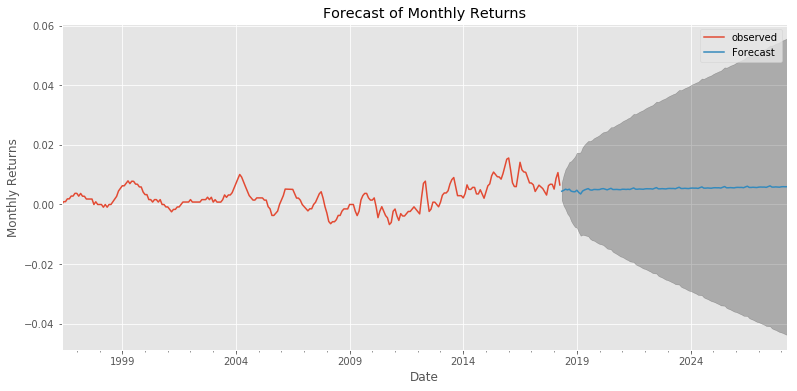

In [85]:
#get a forecast steps ahead in the future
#10 years in the future = 120 steps
prediction = output.get_forecast(steps=120)

#get confidence intervals of forecasts
pred_conf = prediction.conf_int()

#plot future predictions with confidence intervals

ax = TS_76017.plot(label='observed', figsize=(13,6))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:, 0],
                   pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_title('Forecast of Monthly Returns')
ax.set_ylabel('Monthly Returns')

plt.legend()
plt.show()

# 6) Findings

After performing time series analyses on the five zipcodes and forecasting the returns up to ten years, I would recommend the real estate investment company to invest in the top three zipcodes:
1. 76028(Burleson, TX) <br>
2. 75104(Cedar Hill, TX) <br>
3. 75165(Waxahachie, TX) <br>

The other two zipcodes do not have as high returns as the top three.

In [86]:
# put the future returns in a dataframe
tot_returns = [ret_75165, ret_75052, ret_75104, ret_76028, ret_76017]
tot_returns = pd.DataFrame(tot_returns, columns=['ZipCode', '1-year', '3-year', '5-year', '10-year'])
tot_returns.sort_values('10-year', ascending=False)

,ZipCode,1-year,3-year,5-year,10-year
3,76028,0.184105,0.659615,1.326079,4.486261
2,75104,0.110360,0.369073,0.688067,1.874666
0,75165,0.084863,0.276793,0.502679,1.273411
1,75052,0.108583,0.174591,0.185506,0.187573
4,76017,0.078759,0.115110,0.119104,0.119586


# 7) Future Work

Having more domain knowledge in real estate investing will improve analysis. These models can be improved by taking other external varaibles into account. These other variables can include tax rates, crime rates, school district ratings and interest rates.
It may to interesting to compare a time series analysis on just housing prices and the monthly returns discovered in this analysis. The results from both would improve the decision making process.